In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import nibabel as nib

from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind
from statsmodels.stats import multitest
import scipy.linalg as la
import itertools
import random
import math

In [2]:
DATADIR = '/home/jiunchoi/OFD/OFD_BHV_clean'
group = 2
sub = 1
groupsub = '0'+str(group)+'0'+str(sub)

In [3]:
def extract_recalledidx(group):
    keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

    data_transcript = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    data_recs = np.array(data_transcript[keys])

    recalled_evidx=[]
    recalled_evs = []
    for i in range(len(sharedeb)):
        count=0
        for j in range(3):
            if (type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False) and (data_recs[i,j]!=0):
                count+=1
        if count==3:
            if sharedeb[i] not in recalled_evidx:
                recalled_evidx.append(sharedeb[i])
                recalled_evs.append(data_recs[i,:])
    return recalled_evs

def get_boundary(group,sub,run):
    groupsub = '0'+str(group)+'0'+str(sub)
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-0{group}/sub-{groupsub}_run-{run}_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []
    endidx = [0]
    for t in range (len(posthoc_data['Unnamed: 0'])-1):
        if posthoc_data['Unnamed: 0'][t]+1 != posthoc_data['Unnamed: 0'][t+1]:
            endidx.append(t)
    endidx.append(len(posthoc_data['Unnamed: 0'])-1)
    if len(endidx)>2:
        segcol = np.array(posthoc_data['segmentation'][endidx[run-1]+1:endidx[run]+1])
    else:
        segcol = np.array(posthoc_data['segmentation'])

    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    # working for subs with only 1 run
    tmpstart = sentstartend[0][0]
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:     
            tmpend = sentstartend[i][1]     
            eventstartend.append([tmpstart,tmpend])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[len(segcol)-1][1]
    eventstartend.append([tmpstart,tmpend]) 
    
    return eventstartend

def get_motion_params(subn,task,run):
    fname = f'/home/jiunchoi/OFD/OFD_DATA/derivatives/sub-{subn}/func/sub-{subn}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    compounds = pd.read_csv(fname, delimiter='\t')

    confound_labels =  ['trans_x', 
                    'trans_y', 
                    'trans_z',
                    'rot_x',
                    'rot_y',
                    'rot_z',
                    'trans_x_derivative1',
                    'trans_y_derivative1',
                    'trans_z_derivative1',
                    'rot_x_derivative1',
                    'rot_y_derivative1',
                    'rot_z_derivative1',
                    'trans_x_power2',
                    'trans_y_power2',
                    'trans_z_power2',
                    'rot_x_power2',
                    'rot_y_power2',
                    'rot_z_power2',
                    'trans_x_derivative1_power2',
                    'trans_y_derivative1_power2',
                    'trans_z_derivative1_power2',
                    'rot_x_derivative1_power2',
                    'rot_y_derivative1_power2',
                    'rot_z_derivative1_power2']
    X_motion = compounds[confound_labels]
    X_motion = np.nan_to_num(X_motion)
    return X_motion

def mot_regout(groupsub,task,run,data):
    motparam = get_motion_params(groupsub, task, run)

    data_mean = data.mean(0)
    data = data - data_mean
    coef, _, _, _ = la.lstsq(motparam, data)
    # remove trends and add back mean of the data
    data_clean = data - motparam.dot(coef) + data_mean

    return data_clean


MASKDIR = '/home/jiunchoi/OFD/source/'
DATADIR = '/home/jiunchoi/OFD/OFD_DATA/derivatives/'
BN_atlas = nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata()

def load_brain(group,sub,run):
    task = 'RECALL'
    BN_parcels = np.zeros((246), dtype='object')
    groupsub = '0'+str(group)+'0'+str(sub)
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_{task}_{run}_sc_dt_sm.nii.gz').get_fdata()
    for roi in range (1,246+1):
        roi_data = fmri_data[BN_atlas==roi, :].T #(Time, Voxels)
        roi_data = zscore(roi_data, axis=0)
        roi_data = np.nan_to_num(roi_data)
        BN_parcels[roi-1] = roi_data
    return BN_parcels

In [4]:
groups=[2,3,4,5]
group_brain = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        sub_brain = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        else:
            runs = [1]
        for run in runs:
            sub_brain.append(load_brain(group,sub,run))
        group_brain[group-2,sub-1] = sub_brain

In [5]:
# groups=[2,3,4,5]; roi=245

# group_evpatterns = []
# for group in groups:
#     recalled_evs = extract_recalledidx(group)
#     event_patterns = np.zeros_like(recalled_evs,dtype='object')
#     for sub in [1,2,3]:
#         if (group==2 and sub==1):
#             runs = [1,2,3]
#         else:
#             runs = [1]
#         eventstartend = []
#         for run in runs:
#             eventstartend.extend(get_boundary(group,sub,run))

#         for e in range(len(recalled_evs)):
#             ev_from_recall = str(recalled_evs[e][sub-1]).split(',')
#             if len(ev_from_recall) > 1:
#                 single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
#                 for efr in ev_from_recall[1:]:
#                     single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(efr)-1]))
#                 single_pattern = group_brain[group-2,sub-1][run-1][roi][int(single_pattern_timepoint[0,0]/1000):int(single_pattern_timepoint[0,1]/1000),:]
#                 for s in range(1, single_pattern_timepoint.shape[-1]):
#                     single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][run-1][roi][int(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
#             else:
#                 single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
#                 single_pattern = group_brain[group-2,sub-1][run-1][roi][int(single_pattern_timepoint[0]/1000):int(single_pattern_timepoint[1]/1000),:]
#             event_pattern = np.mean(single_pattern,axis=0)
#             event_patterns[e,sub-1] = event_pattern
#     group_evpatterns.append(event_patterns)

/home/jiunchoi/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jiunchoi/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jiunchoi/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jiunchoi/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [7]:
idx = [0,1,2]
eventwise_rs = np.zeros((246,len(groups)),dtype='object')

menu_evs = [[8],[10,11,12,14,15,16,17],[3,4],[5,6,7,8,9,10,11,12]] #순서대로 group
task2_evs = [[9,10,11,12,13,14,15,16],[8,9,18,19],['nan'],[4,14,15,16]]
task13_evs = []

for g,group in enumerate(groups):
    recalled_evs = extract_recalledidx(group)
    task13_ev = [i for i in range(len(recalled_evs))]
    subtracted = [x for x in task13_ev if x not in menu_evs[g] and task2_evs[g]]
    task13_evs.append(subtracted)

entire_roigroups_evpatterns = np.zeros((246,len(groups)),dtype='object') #roi, group, sub, event

for roi in range(246):
    for group in groups:
        recalled_evs = extract_recalledidx(group)
        event_patterns = np.zeros_like(recalled_evs,dtype='object')
        for sub in [1,2,3]:
            if (group==2 and sub==1):
                runs = [1,2,3]
            else:
                runs = [1]
            eventstartend = []
            runidx = []
            for run in runs:
                evse = get_boundary(group,sub,run)
                eventstartend.extend(evse)
                runidx.extend([run]*len(evse))
                
            for e in range(len(recalled_evs)):
                ev_from_recall = str(recalled_evs[e][sub-1]).split(',')

                if len(ev_from_recall) > 1:
                    single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                    for efr in ev_from_recall[1:]:
                        single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(float(efr))-1]))
                    single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0,0]/1000):math.ceil(single_pattern_timepoint[0,1]/1000),:]
                    for s in range(1, single_pattern_timepoint.shape[-1]):
                        single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][runidx[math.trunc(float(ev_from_recall[0]))-1]-1][roi][math.ceil(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
                else:
                    single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                    single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0]/1000):math.ceil(single_pattern_timepoint[1]/1000),:]
                event_pattern = np.mean(single_pattern,axis=0)
                event_patterns[e,sub-1] = event_pattern
            entire_roigroups_evpatterns[roi,group-2] = event_patterns

In [8]:
# calculate ISPC
eventwise_rs = np.zeros((246,len(groups)),dtype='object')
for roi in range(246):
    for group in groups:
        eventwise_r = np.zeros((len(entire_roigroups_evpatterns[roi][group-2]),3))
        for e in range(len(eventwise_r)):
            for j in range (3):
                a = idx[j-2]
                b = idx[j-1]
                c = idx[j]
            
                pattern_1 = entire_roigroups_evpatterns[roi][group-2][e,a]
                pattern_2 = np.mean((entire_roigroups_evpatterns[roi][group-2][e,b],entire_roigroups_evpatterns[roi][group-2][e,c]),axis=0)
                eventwise_r[e,a] = pearsonr(pattern_1, pattern_2)[0]
        eventwise_rs[roi,group-2] = eventwise_r

In [25]:
n_permutation = 1000
permuted_stats = np.zeros((n_permutation,2))
roi_t_thres = np.zeros((246,2)) #mean, sig count

for roi in range(246):
    for i in range(n_permutation):
        chosen_evs = np.zeros((4,3)) #group, conds
        chosen_evpatterns = np.zeros((4,3,2)) #group, rs, conditions
        for group in groups:
            chosen_evs[group-2,0] = random.choice(menu_evs[group-2]) #menu
            # chosen_evs[group-2,1] = random.choice(task2_evs[group-2]) #task2
            chosen_evs[group-2,2] = random.choice(task13_evs[group-2]) #task13
            chosen_evpatterns[group-2,:,0] = eventwise_rs[roi,group-2][int(chosen_evs[group-2,0])]
            chosen_evpatterns[group-2,:,1] = eventwise_rs[roi,group-2][int(chosen_evs[group-2,2])]

        group1 = chosen_evpatterns[:,:,0].flatten()
        group2 = chosen_evpatterns[:,:,1].flatten()

        t_stat, p_values = ttest_ind(group1, group2)
        corrected_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
        permuted_stats[i,:] = [t_stat, corrected_p_values]
    # print(np.mean(permuted_stats[:,0]),np.mean(permuted_stats[:,1]))
    if np.mean(permuted_stats[:,1])<0.05:
        roi_t_thres[roi,0] = np.mean(permuted_stats[:,0])
    roi_t_thres[roi,1] = np.count_nonzero(permuted_stats[:,1] < 0.05)

/tmp/ipykernel_6842/829582770.py:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  permuted_stats[i,:] = [t_stat, corrected_p_values]


0.8287623959535195 0.33279310939770507
1.112950569770495 0.3424700008351956
0.5020024694610059 0.3862556507533591
0.23387993648126446 0.3881995544879814
0.4095413257773322 0.40208825126211767
-0.015645355316227034 0.44282193285754157
-0.5345126303092985 0.38412530864352085
0.6413854121461289 0.37989033140834927
-1.576399980090586 0.23953291343495564
-0.9897554124270207 0.3558093051605832
0.5563678701177799 0.42141923127872427
1.0774471907314218 0.32262572250192884
-1.5476918353512814 0.269048740156655
-0.34276194706488683 0.39941982263381764
0.7497698998430737 0.4024025662594425
-0.07613215098992174 0.4651413615130283
-1.1923476634243078 0.32735698595749074
0.7912694015646475 0.4342291064616077
-1.8158459517195245 0.22723460516743932
1.3371720824525948 0.292212190171174
-1.2332467859699423 0.3044103434283264
0.3580643931178555 0.3976989689399149
0.5269246411241052 0.37361324147310754
-0.3269016326311441 0.4518171968957622
-0.2912193667821086 0.41976051248172597
0.18336562544556695 0.50

In [44]:
n_permutation = 1000
permuted_stats = np.zeros((n_permutation,2))
roi_t_thres = np.zeros((246,2)) #mean, sig count

for roi in range(246):
    for i in range(n_permutation):
        chosen_evs = np.zeros((4,3)) #group, conds
        chosen_evpatterns = np.zeros((4,3,2)) #group, rs, conditions
        for group in [2,3,5]:
            chosen_evs[group-2,0] = random.choice(menu_evs[group-2]) #menu
            # chosen_evs[group-2,1] = random.choice(task2_evs[group-2]) #task2
            chosen_evs[group-2,2] = random.choice(task13_evs[group-2]) #task13
            chosen_evpatterns[group-2,:,0] = eventwise_rs[roi,group-2][int(chosen_evs[group-2,0])]
            chosen_evpatterns[group-2,:,1] = eventwise_rs[roi,group-2][int(chosen_evs[group-2,2])]
        chosen_evpatterns = np.delete(chosen_evpatterns, 2, axis=0)

        group1 = chosen_evpatterns[:,:,0].flatten()
        group2 = chosen_evpatterns[:,:,1].flatten()

        t_stat, p_values = ttest_ind(group1, group2)
        corrected_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
        permuted_stats[i,:] = [t_stat, corrected_p_values]
    # print(roi,np.mean(permuted_stats[:,0]),np.mean(permuted_stats[:,1]),np.count_nonzero(permuted_stats[:,1] < 0.05))
    if np.mean(permuted_stats[:,1])<0.05:
        roi_t_thres[roi,0] = np.mean(permuted_stats[:,0])
    roi_t_thres[roi,1] = np.count_nonzero(permuted_stats[:,1] < 0.05)

/tmp/ipykernel_6842/1178135045.py:22: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  permuted_stats[i,:] = [t_stat, corrected_p_values]


0 0.37464350211172337 0.3823854270096484 162
1 1.0482523563906947 0.34212638728850386 210
2 0.12655958059720138 0.4259849116529815 97
3 0.08849651860128284 0.4035878969165105 143
4 0.05504919470975404 0.42046165454689044 109
5 -0.017051232401415282 0.4237982551332751 128
6 -0.23354759406957368 0.3940524592787875 163
7 0.7061340479319529 0.41932862433707363 90
8 -0.8951238026138857 0.4197906600902096 129
9 -0.5998586779471766 0.3894951526185379 162
10 0.6045000370181413 0.39599301641097473 139
11 1.10399905022959 0.2891558070897844 257
12 -1.2095986704361172 0.34400987908153174 239
13 -0.7031770636549004 0.3705164616880106 189
14 0.8802818614651916 0.3653607743469191 202
15 0.5227805401697204 0.42814567643331564 100
16 -2.2542944828583775 0.17713246968259203 474
17 -0.6069173607242929 0.39775883666992207 157
18 -1.5108613172276233 0.29256893278151413 299
19 1.641127900118688 0.2412719450877285 368
20 -1.306592041021665 0.29006534911912685 295
21 0.3680020063254972 0.4084005092282832 122

(array([45., 76., 60., 30., 17.,  7.,  5.,  3.,  1.,  2.]),
 array([  0. ,  78.5, 157. , 235.5, 314. , 392.5, 471. , 549.5, 628. ,
        706.5, 785. ]),
 <BarContainer object of 10 artists>)

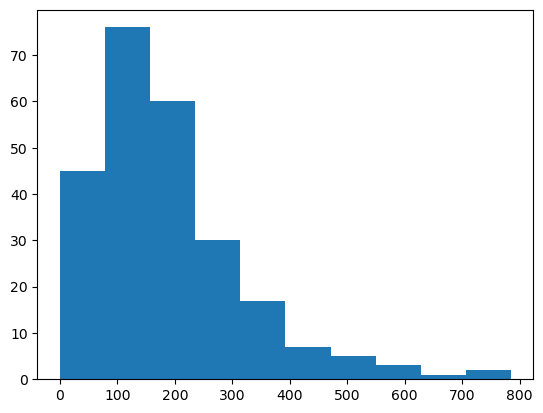

In [53]:
plt.hist(roi_t_thres2[:,1])

In [51]:
MASKDIR = '/home/jiunchoi/OFD/source/'
atlas = np.array(nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata())

empty_brain = np.zeros((atlas.shape))
for i in range(1,247):
    empty_brain[atlas==i] = roi_t_thres2[i-1,1]/1000
empty_brain[empty_brain==0.0] = np.nan
np.save("230524 menu pattern similarity_b.npy", empty_brain)